In [1]:
import pandas as pd
import torch
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

c:\vsc\research\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.9


In [3]:
file_path = 'DB for chromophore_Sci_Data_rev02.csv'

df = pd.read_csv(file_path)

df = df[df["Quantum yield"].notna() & df["Chromophore"].notna() & df["Solvent"].notna()]
df = df[["Chromophore", "Solvent", "Quantum yield"]]
df = df[df["Quantum yield"] >= 0.01]  # take quuntum yields bigger than 0.01
print("Filtered dataset size:", len(df))
df.head()

Filtered dataset size: 12541


,Chromophore,Solvent,Quantum yield
34,O=C([O-])c1ccccc1-c1c2ccc(=O)cc-2oc2cc([O-])ccc12,O,0.950
43,O=C([O-])c1ccccc1C1=c2cc3c4c(c2Oc2c1cc1c5c2CCC...,CO,1.000
71,O=C([O-])c1ccccc1-c1c2cc(Br)c(=O)c(Br)c-2oc2c(...,O,0.200
72,O=C([O-])c1ccccc1-c1c2cc(I)c(=O)c(I)c-2oc2c(I)...,O,0.020
73,O=C([O-])c1c(Cl)c(Cl)c(Cl)c(Cl)c1-c1c2cc(I)c(=...,O,0.018


In [4]:
model = AutoModel.from_pretrained("ibm/MoLFormer-XL-both-10pct", deterministic_eval=True, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("ibm/MoLFormer-XL-both-10pct", trust_remote_code=True)


In [5]:
import os
import torch

CACHE_FILE = "embedding_cache.pt"

def load_cache():
    if os.path.exists(CACHE_FILE):
        return torch.load(CACHE_FILE)
    else:
        return {}  # empty cache

def save_cache(cache):
    torch.save(cache, CACHE_FILE)

In [6]:
def get_embeddings(smiles_list, batch_size=32, max_length=202):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    cache = load_cache()
    all_embeddings = []


    to_compute = [s for s in smiles_list if s not in cache]

    if len(to_compute) > 0:
        print(f"Computing {len(to_compute)} new embeddings on {device}...")


        model.to(device)
        model.eval()

        with torch.no_grad():
            for i in range(0, len(to_compute), batch_size):
                batch = to_compute[i:i+batch_size]

                inputs = tokenizer(
                    batch, padding=True, truncation=True,
                    max_length=max_length, return_tensors="pt"
                ).to(device)


                outputs = model(**inputs)
                embeddings = outputs.pooler_output 


                for s, emb in zip(batch, embeddings):
                    cache[s] = emb.cpu()


        save_cache(cache)

    else:
        print("All embeddings already in cache.")


    ordered = [cache[s] for s in smiles_list]
    return torch.stack(ordered)


In [7]:
chrom_emb = get_embeddings(df["Chromophore"].tolist())
print("Chromophore embeddings shape:", chrom_emb.shape)

solv_emb = get_embeddings(df["Solvent"].tolist())
print("Solvent embeddings shape:", solv_emb.shape)

combined_emb = torch.cat([chrom_emb, solv_emb], dim=1)
print("Combined embedding shape:", combined_emb.shape)

All embeddings already in cache.
Chromophore embeddings shape: torch.Size([12541, 768])
All embeddings already in cache.
Solvent embeddings shape: torch.Size([12541, 768])
Combined embedding shape: torch.Size([12541, 1536])


In [8]:
from sklearn.preprocessing import StandardScaler

chrom_emb_scaled = torch.tensor(StandardScaler().fit_transform(chrom_emb.numpy()), dtype=torch.float32)
solv_emb_scaled = torch.tensor(StandardScaler().fit_transform(solv_emb.numpy()), dtype=torch.float32)
combined_emb = torch.cat([chrom_emb_scaled, solv_emb_scaled], dim=1)

In [9]:
y = torch.tensor(df["Quantum yield"].values, dtype=torch.float32).unsqueeze(1)
X_train, X_test, y_train, y_test = train_test_split(combined_emb, y, test_size=0.2, random_state=42)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

input_dim = combined_emb.shape[1]


regressor = nn.Sequential(
    nn.Linear(input_dim, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 1)
).to(device)  

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(regressor.parameters(), lr=1e-4)

Using device: cuda


In [11]:


epochs = 100
for epoch in range(epochs):
    regressor.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)  
        pred = regressor(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/100 | Training Loss: 0.0726
Epoch 10/100 | Training Loss: 0.0169
Epoch 20/100 | Training Loss: 0.0083
Epoch 30/100 | Training Loss: 0.0061
Epoch 40/100 | Training Loss: 0.0044
Epoch 50/100 | Training Loss: 0.0038
Epoch 60/100 | Training Loss: 0.0034
Epoch 70/100 | Training Loss: 0.0030
Epoch 80/100 | Training Loss: 0.0026
Epoch 90/100 | Training Loss: 0.0024
Epoch 100/100 | Training Loss: 0.0022


In [12]:
regressor.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = regressor(xb)
        y_true.append(yb.cpu())
        y_pred.append(pred.cpu())


y_true = torch.cat(y_true).squeeze().numpy()
y_pred = torch.cat(y_pred).squeeze().numpy()

r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("\nModel Evaluation (based on Chromophore + Solvent Fusion):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


Model Evaluation (based on Chromophore + Solvent Fusion):
R² Score: 0.6042
MAE: 0.1361
RMSE: 0.1887


In [13]:
#Transformer

In [14]:
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_heads=8, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads, dim_feedforward=512, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, chrom, solv):
        chrom = self.embedding(chrom).unsqueeze(1)
        solv = self.embedding(solv).unsqueeze(1)
        x = torch.cat([chrom, solv], dim=1)
        x = self.transformer(x)
        x = x.flatten(1)
        return self.regressor(x)

In [15]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

input_dim = chrom_emb.shape[1]
transformer_model = TransformerRegressor(input_dim=input_dim, hidden_dim=256, num_heads=8, num_layers=2).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=1e-4)

epochs = 100
train_losses = []

for epoch in range(epochs):
    transformer_model.train()
    total_loss = 0
    
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        

        split_idx = xb.shape[1] // 2
        chrom_batch = xb[:, :split_idx]
        solv_batch = xb[:, split_idx:]
        
   
        pred = transformer_model(chrom_batch, solv_batch)
        loss = criterion(pred, yb)
        
       
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch + 1}/{epochs} | Training Loss: {avg_loss:.4f}")

print("Training complete!")

Using device: cuda
Epoch 1/100 | Training Loss: 0.0778
Epoch 10/100 | Training Loss: 0.0239
Epoch 20/100 | Training Loss: 0.0135
Epoch 30/100 | Training Loss: 0.0097
Epoch 40/100 | Training Loss: 0.0076
Epoch 50/100 | Training Loss: 0.0063
Epoch 60/100 | Training Loss: 0.0050
Epoch 70/100 | Training Loss: 0.0048
Epoch 80/100 | Training Loss: 0.0040
Epoch 90/100 | Training Loss: 0.0034
Epoch 100/100 | Training Loss: 0.0032
Training complete!



=== Transformer Model Evaluation ===
R² Score: 0.6109
MAE: 0.1298
RMSE: 0.1871


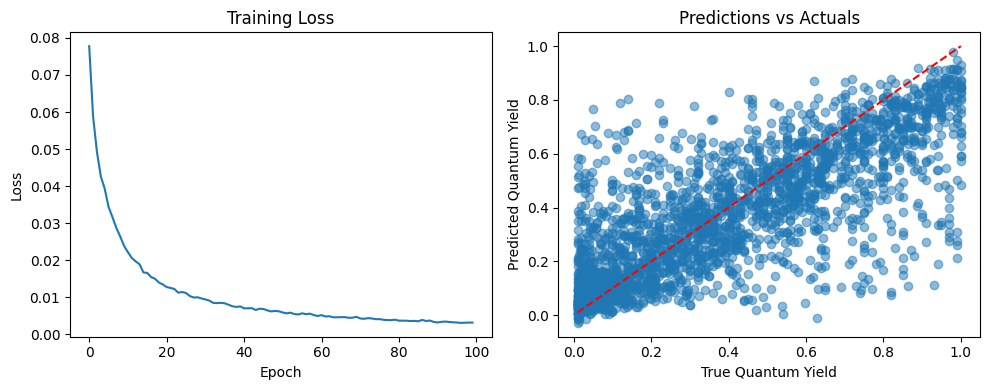

In [16]:

transformer_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        

        split_idx = xb.shape[1] // 2
        chrom_batch = xb[:, :split_idx]
        solv_batch = xb[:, split_idx:]
        
        pred = transformer_model(chrom_batch, solv_batch)
        y_true.append(yb.cpu())
        y_pred.append(pred.cpu())

y_true = torch.cat(y_true).squeeze().numpy()
y_pred = torch.cat(y_pred).squeeze().numpy()

r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("\n=== Transformer Model Evaluation ===")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")

plt.subplot(1, 2, 2)
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("True Quantum Yield")
plt.ylabel("Predicted Quantum Yield")
plt.title("Predictions vs Actuals")
plt.tight_layout()
plt.show()

In [17]:
class CrossAttentionRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_heads=8, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        
    
        self.cross_attn_layers = nn.ModuleList([
            nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True)
            for _ in range(num_layers)
        ])
        
        
        self.norms = nn.ModuleList([
            nn.LayerNorm(hidden_dim) for _ in range(num_layers * 2)
        ])
        
       
        self.ffns = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim * 4),
                nn.ReLU(),
                nn.Linear(hidden_dim * 4, hidden_dim)
            )
            for _ in range(num_layers)
        ])
        
        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, chrom, solv):
       
        chrom = self.embedding(chrom).unsqueeze(1) 
        solv = self.embedding(solv).unsqueeze(1)   
        
        for i, (attn, norm1, norm2, ffn) in enumerate(zip(
            self.cross_attn_layers, 
            self.norms[::2], 
            self.norms[1::2], 
            self.ffns
        )):
            attn_out, _ = attn(chrom, solv, solv)
            chrom = norm1(chrom + attn_out)
            ffn_out = ffn(chrom)
            chrom = norm2(chrom + ffn_out)
            
            attn_out, _ = attn(solv, chrom, chrom)
            solv = norm1(solv + attn_out)
            ffn_out = ffn(solv)
            solv = norm2(solv + ffn_out)
        
    
        x = torch.cat([chrom, solv], dim=-1).flatten(1)
        return self.regressor(x)

In [ ]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

input_dim = chrom_emb.shape[1]
transformer_model = CrossAttentionRegressor(input_dim=input_dim, hidden_dim=256, num_heads=8, num_layers=2).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=1e-4)

epochs = 100
train_losses = []

for epoch in range(epochs):
    transformer_model.train()
    total_loss = 0
    
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        
        split_idx = xb.shape[1] // 2
        chrom_batch = xb[:, :split_idx]
        solv_batch = xb[:, split_idx:]
        

        pred = transformer_model(chrom_batch, solv_batch)
        loss = criterion(pred, yb)
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch + 1}/{epochs} | Training Loss: {avg_loss:.4f}")

print("Training complete")

Using device: cuda
Epoch 1/100 | Training Loss: 0.0764
Epoch 10/100 | Training Loss: 0.0232
Epoch 20/100 | Training Loss: 0.0124
Epoch 30/100 | Training Loss: 0.0080
Epoch 40/100 | Training Loss: 0.0062
Epoch 50/100 | Training Loss: 0.0050
Epoch 60/100 | Training Loss: 0.0044
Epoch 70/100 | Training Loss: 0.0033
Epoch 80/100 | Training Loss: 0.0026
Epoch 90/100 | Training Loss: 0.0032
Epoch 100/100 | Training Loss: 0.0026
Training complete!



=== Cross-Attention Model Evaluation ===
R² Score: 0.6311
MAE: 0.1261
RMSE: 0.1822


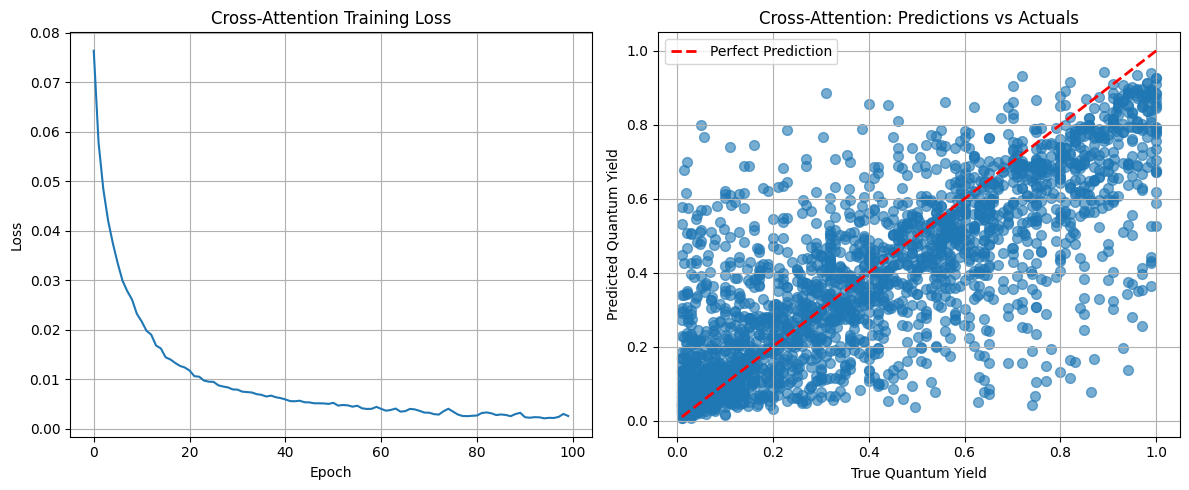


Residuals - Mean: 0.0256, Std: 0.1804


In [19]:
transformer_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        
        split_idx = xb.shape[1] // 2
        chrom_batch = xb[:, :split_idx]
        solv_batch = xb[:, split_idx:]
        
        pred = transformer_model(chrom_batch, solv_batch)
        y_true.append(yb.cpu())
        y_pred.append(pred.cpu())

y_true = torch.cat(y_true).squeeze().numpy()
y_pred = torch.cat(y_pred).squeeze().numpy()

r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("\n=== Cross-Attention Model Evaluation ===")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Cross-Attention Training Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_true, y_pred, alpha=0.6, s=50)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel("True Quantum Yield")
plt.ylabel("Predicted Quantum Yield")
plt.title("Cross-Attention: Predictions vs Actuals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

residuals = y_true - y_pred
print(f"\nResiduals - Mean: {residuals.mean():.4f}, Std: {residuals.std():.4f}")